In [1]:
import torch
import os
import pathlib
import numpy as np
import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import requests
import zipfile
import re

from tqdm.auto import tqdm
from utils.classification import (
    NLPClassificationDatasetCustom,
    train, 
    validate
)
from urllib.parse import urlparse
from collections import Counter
from torch.utils.data import DataLoader, Subset
from attention.transformer_linear_decoder import Transformer

plt.style.use('ggplot')

In [2]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
!nvidia-smi

Thu May 25 21:50:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   46C    P0    85W / 370W |    294MiB / 10009MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
def unzip(file_path, unzip_path=None):
    """
    Unzip a file.
    
    :param path: Path to the file.
    :param unzip_path: Directory path to unzip the file. If not
        provided, the file will be extracted in the current working directory.
    """
    print('Unzipping file...')
    with zipfile.ZipFile(file_path) as z:
        if unzip_path is None:
            """
            Extract in the current working directory
            """
            z.extractall()
        else:
            z.extractall(unzip_path)
        print("Extracted all")

def download_file(
    path=os.getcwd(), 
    url=None, 
    file_save_name=None,
    extract=False
):
    """
    Download a file given a download URL.
    
    :param url: Download URL for the weight file.
    :param file_save_name: String name to save the file on to disk.
    :param dir: Directory to save the downloaded file in
    """
    data_dir = pathlib.Path(path)
    print(f"Downloading files to {data_dir}")
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    # Download the file if not present.
    if file_save_name is None:
        parse_url = urlparse(url)
        parse_path = parse_url.path
        file_save_name = parse_path.split(os.path.sep)[-1]
        print(file_save_name)
    if not os.path.exists(os.path.join(data_dir, file_save_name)):
        print(f"Downloading file")
        file = requests.get(url, stream=True)
        total_size = int(file.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(
            total=total_size, 
            unit='iB', 
            unit_scale=True
        )
        with open(os.path.join(data_dir, file_save_name), 'wb') as f:
            for data in file.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
    else:
        print('File already present')
        
    # Unzip file or not
    if extract:
        unzip(os.path.join(data_dir, file_save_name), data_dir)

In [5]:
KAGGLE, COLAB, LOCAL = False, False, False
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
    KAGGLE = True
    print('Running on Kaggle')
if 'google.colab' in str(get_ipython()):
    COLAB = True
    print('Running on CoLab')
if not KAGGLE and not COLAB:
    LOCAL = True
    print('Running on Local')

Running on Local


In [6]:
url = 'https://www.dropbox.com/s/cyua81yf0w18llv/aclImdb.zip?dl=1'

if not LOCAL:
    data_path = os.path.join('input')
else:
    data_path = os.path.join('..', 'input')

os.makedirs(os.path.join(data_path), exist_ok=True)
        
data_dir = data_path
# Download and extract.
download_file(data_dir, url, extract=True)

aclImdb.zip
File already present
Unzipping file...
Extracted all


## Directory Setup

In [7]:
OUTPUTS_DIR = 'outputs/imdb_movie_review_classification_tiktoken'
os.makedirs(OUTPUTS_DIR, exist_ok=True)

data_dir = os.path.join('../input', 'aclImdb')
dataset_dir = os.path.join(data_dir)
train_dir = os.path.join(dataset_dir, 'train')
print(os.listdir(dataset_dir))
print(os.listdir(train_dir))

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']
['labeledBow.feat', 'neg', 'pos', 'unsup', 'unsupBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']


## Prepare the Dataset

Let's find the longest review in the entire training set. As this will also contain the `<br>` tags, we will take the average of that.

We will pad the smaller sentences to this average length and truncate the longer sentences to the average length.

In [8]:
def find_longest_length(text_file_paths):
    """
    Find the longest review length in the entire training set. 

    :param text_file_paths: List, containing all the text file paths.

    Returns:
        max_len: Longest review length.
    """
    max_length = 0
    for path in text_file_paths:
        with open(path, 'r') as f:
            text = f.read()
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus = [
                word for word in text.split()
            ]
        if len(corpus) > max_length:
            max_length = len(corpus)
    return max_length

file_paths = []
file_paths.extend(glob.glob(os.path.join(
    dataset_dir, 'train', 'pos', '*.txt'
)))
file_paths.extend(glob.glob(os.path.join(
    dataset_dir, 'train', 'neg', '*.txt'
)))
longest_sentence_length = find_longest_length(file_paths)
print(f"Longest review length: {longest_sentence_length} words")

Longest review length: 2450 words


In [9]:
def find_avg_sentence_length(text_file_paths):
    """
    Find the average sentence in the entire training set. 

    :param text_file_paths: List, containing all the text file paths.

    Returns:
        avg_len: Average length.
    """
    sentence_lengths = []
    for path in text_file_paths:
        with open(path, 'r') as f:
            text = f.read()
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus = [
                word for word in text.split()
            ]
        sentence_lengths.append(len(corpus))
    return sum(sentence_lengths)/len(sentence_lengths)

file_paths = []
file_paths.extend(glob.glob(os.path.join(
    dataset_dir, 'train', 'pos', '*.txt'
)))
file_paths.extend(glob.glob(os.path.join(
    data_dir, 'train', 'neg', '*.txt'
)))
average_length = find_avg_sentence_length(file_paths)
print(f"Average review length: {average_length} words")

Average review length: 229.70464 words


In [10]:
# Max sentence length to consider from a text file.
# If a sentence is shorter than this, it will be padded. 
# We can use the max sentence length from the dataset or any 
# reasonnable choice. 232.76 is the average length without the <br> tags.
# 236.70 is the average lenght with the <br> tags.
# MAX_LEN = int(longest_sentence_length)
MAX_LEN = 512
# Use these many top words from the dataset. If -1, use all words.
NUM_WORDS = 50304 # Vocabulary size.
# Batch size.
BATCH_SIZE = 16
VALID_SPLIT = 0.20

### Helper Functions 

A few helper functions to prepare the dataset.

In [11]:
def find_word_frequency(text_file_paths, most_common=None):
    """
    Create a list of tuples of the following format,
    [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    where the number represents the frequency of occurance of 
    the word in the entire dataset.

    :param text_file_paths: List, containing all the text file paths.
    :param most_common: Return these many top words from the dataset.
        If `most_common` is None, return all. If `most_common` is 3,
        returns the top 3 tuple pairs in the list.

    Returns:
        sorted_words: A list of tuple containing each word and it's
        frequency of the format ('ho', 2), ('hello', 1), ...]
    """
    # Add all the words in the entire dataset to `corpus` list.
    corpus = []
    for path in text_file_paths:
        with open(path, 'r') as f:
            text = f.read()
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus.extend([
                word for word in text.split()
            ])
    count_words = Counter(corpus)
    # Create a dictionary with the most common word in the corpus 
    # at the beginning.
    # `word_frequency` will be like 
    word_frequency = count_words.most_common(n=most_common) # Returns all if n is `None`.
    return word_frequency


# Sanity check
with open('words.txt', 'w') as f:
    f.writelines(
        'AN IMAGINE DRAGONS REFERENCE...\n'
        'Hello, Hello, Hello, let me tell you what it is like to be...\n'
        'When the days are cold, and the cards all fold...'
    )
sample1 = find_word_frequency(
    ['words.txt'],
    None
)
print('Frequency of all unique words:', sample1)
print('\n')
sample2 = find_word_frequency(
    ['words.txt'],
    3
)
print('Frequency of top 3 unique words:', sample2)

Frequency of all unique words: [('Hello,', 3), ('the', 2), ('AN', 1), ('IMAGINE', 1), ('DRAGONS', 1), ('REFERENCE...', 1), ('let', 1), ('me', 1), ('tell', 1), ('you', 1), ('what', 1), ('it', 1), ('is', 1), ('like', 1), ('to', 1), ('be...', 1), ('When', 1), ('days', 1), ('are', 1), ('cold,', 1), ('and', 1), ('cards', 1), ('all', 1), ('fold...', 1)]


Frequency of top 3 unique words: [('Hello,', 3), ('the', 2), ('AN', 1)]


In [12]:
def word2int(input_words, num_words):
    """
    Create a dictionary of word to integer mapping for each unique word.

    :param input_words: A list of tuples containing the words and 
        theiry frequency. Should be of the following format,
        [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    :param num_words: Number of words to use from the `input_words` list 
        to create the mapping. If -1, use all words in the dataset.

    Returns:
        int_mapping: A dictionary of word and a integer mapping as 
            key-value pair. Example, {'Hello,': 1, 'the': 2, 'let': 3}
    """

    if num_words > -1:
        int_mapping = {
            w:i+1 for i, (w, c) in enumerate(input_words) \
                if i <= num_words - 1 # -1 to avoid getting (num_words + 1) integer mapping.
        }
    else:
        int_mapping = {w:i+1 for i, (w, c) in enumerate(input_words)}
    return int_mapping

# Sanity check.
int_mapping_1 = word2int(sample1, num_words=-1) 
print(int_mapping_1)
int_mapping_2 = word2int(sample1, num_words=3) 
print(int_mapping_2)
int_mapping_3 = word2int(sample2, num_words=-1)
print(int_mapping_3)

{'Hello,': 1, 'the': 2, 'AN': 3, 'IMAGINE': 4, 'DRAGONS': 5, 'REFERENCE...': 6, 'let': 7, 'me': 8, 'tell': 9, 'you': 10, 'what': 11, 'it': 12, 'is': 13, 'like': 14, 'to': 15, 'be...': 16, 'When': 17, 'days': 18, 'are': 19, 'cold,': 20, 'and': 21, 'cards': 22, 'all': 23, 'fold...': 24}
{'Hello,': 1, 'the': 2, 'AN': 3}
{'Hello,': 1, 'the': 2, 'AN': 3}


In [13]:
print(len(int_mapping_2))

3


## Prepare PyTorch Datasets and Data Loaders

In [14]:
# List of all file paths.
file_paths = []
file_paths.extend(glob.glob(os.path.join(
    dataset_dir, 'train', 'pos', '*.txt'
)))
file_paths.extend(glob.glob(os.path.join(
    dataset_dir, 'train', 'neg', '*.txt'
)))


test_file_paths = []
test_file_paths.extend(glob.glob(os.path.join(
    dataset_dir, 'test', 'pos', '*.txt'
)))
test_file_paths.extend(glob.glob(os.path.join(
    dataset_dir, 'test', 'neg', '*.txt'
)))

In [15]:
# Get the frequency of all unqiue words in the dataset.
word_frequency = find_word_frequency(file_paths)
# Assign a specific intenger to each word.
int_mapping = word2int(word_frequency, num_words=NUM_WORDS)

In [16]:
print(len(int_mapping))

50304


In [17]:
dataset = NLPClassificationDatasetCustom(
    file_paths, word_frequency, int_mapping, MAX_LEN
)

dataset_size = len(dataset)
# Calculate the validation dataset size.
valid_size = int(VALID_SPLIT*dataset_size)
# Radomize the data indices.
indices = torch.randperm(len(dataset)).tolist()
# Training and validation sets.
dataset_train = Subset(dataset, indices[:-valid_size])
dataset_valid = Subset(dataset, indices[-valid_size:])

dataset_test = NLPClassificationDatasetCustom(
    test_file_paths, word_frequency, int_mapping, MAX_LEN
)

# dataset_valid = NLPClassificationDataset()
print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_valid)}")
print(f"Number of test samples: {len(dataset_test)}")

Number of training samples: 20000
Number of validation samples: 5000
Number of test samples: 25000


In [18]:
print(dataset_train[0])

{'text': tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0

In [19]:
# Integer to word mapping for the training dataset.
int2word_train = {value: key for key, value in int_mapping.items()}

In [20]:
# Print a sample input and its label.
inputs = ''
for x in dataset_train[0]['text']:
    if x != 0:
        inputs += ' ' + int2word_train[int(x)]
print(inputs)
print('#'*25)
if int(dataset_train[0]['label']) == 1:
    label = 'Positive'
else:
    label = 'Negative'
print('Label:', label)

 i love a good sappy love story and im a guy but when i rented love story i prayed for the end to come as quickly and as possible and just the opposite for as alienated and irritated the heck out of me within the first 15 minutes when we learn that she has been diagnosed with a life threatening illness i couldnt help but wonder if her death would be such a terrible loss for poor or if anyone watching this film would even care if she didnt die her grating personality would probably have pushed over the edge and eventually landed them in divorce love this movie but its one of the worst of the 70s
#########################
Label: Negative


In [21]:
train_loader = DataLoader(
    dataset_train, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=4
)

valid_loader = DataLoader(
    dataset_valid, 
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=4
)

test_loader = DataLoader(
    dataset_test, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

## Model

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [23]:
model = Transformer(
    embed_dim=512, 
    src_vocab_size=NUM_WORDS + 1, # +1 for padding (0) token 
    seq_len=MAX_LEN,
    num_layers=6, 
    expansion_factor=4, 
    n_heads=8,
    task='CLS',
    num_classes=1
).to(device)

## Training

In [24]:
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(
    model.parameters(), 
    lr=0.0001,
)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

Transformer(
  (encoder): TransformerEncoder(
    (embedding): Embedding(
      (embed): Embedding(50305, 512)
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadAttention(
          (q): Linear(in_features=64, out_features=64, bias=True)
          (k): Linear(in_features=64, out_features=64, bias=True)
          (v): Linear(in_features=64, out_features=64, bias=True)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): 

In [25]:
epochs = 5
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                criterion, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss}, training acc: {train_epoch_acc}")
    print(f"Validation loss: {valid_epoch_loss}, validation acc: {valid_epoch_acc}")

    # Save model.
    torch.save(
        model, os.path.join(OUTPUTS_DIR, 'model.pth')
    )
    print('-'*50)

[INFO]: Epoch 1 of 5
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

/mnt/wwn-0x500a0751e6282b63-part2/my_data/Data_Science/Projects/NLP_Text_Sequence/attention_is_all_you_need/examples/utils/classification.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).to(device)


Validation


  0%|          | 0/313 [00:00<?, ?it/s]

/mnt/wwn-0x500a0751e6282b63-part2/my_data/Data_Science/Projects/NLP_Text_Sequence/attention_is_all_you_need/examples/utils/classification.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).to(device)


Training loss: 0.7116695058345794, training acc: 53.635
Validation loss: 0.6694318534086307, validation acc: 61.08
--------------------------------------------------
[INFO]: Epoch 2 of 5
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

Training loss: 0.5935487943172455, training acc: 67.915
Validation loss: 0.566828658119939, validation acc: 71.58
--------------------------------------------------
[INFO]: Epoch 3 of 5
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

Training loss: 0.4867502630829811, training acc: 76.515
Validation loss: 0.6213419507867612, validation acc: 70.6
--------------------------------------------------
[INFO]: Epoch 4 of 5
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

Training loss: 0.43392077525258066, training acc: 79.91
Validation loss: 0.499613441503086, validation acc: 77.38000000000001
--------------------------------------------------
[INFO]: Epoch 5 of 5
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

Training loss: 0.39721534297466277, training acc: 81.875
Validation loss: 0.48035237412102305, validation acc: 78.10000000000001
--------------------------------------------------


In [26]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='blue', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='red', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(OUTPUTS_DIR, 'accuracy.png'))
    plt.show()
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(OUTPUTS_DIR, 'loss.png'))
    plt.show()

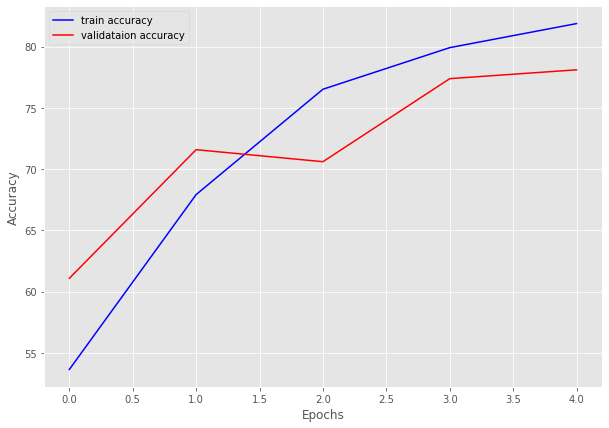

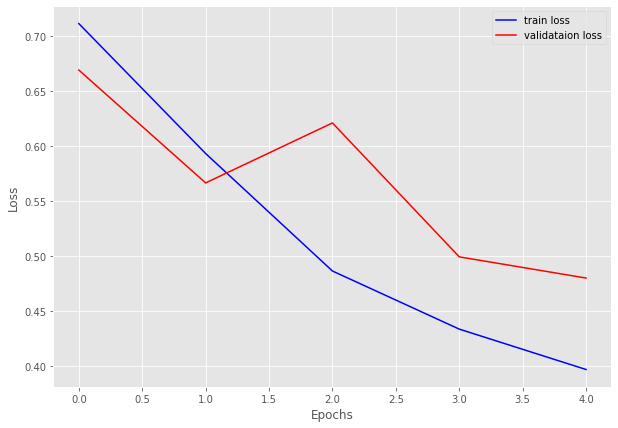

In [27]:
save_plots(train_acc, valid_acc, train_loss, valid_loss)

## Testing

In [28]:
trained_model = torch.load(
    os.path.join(OUTPUTS_DIR, 'model.pth')
)

In [29]:
test_loss, test_acc = validate(
    trained_model, 
    test_loader,  
    criterion, 
    device
)

print(f"Test loss: {test_loss}, test acc: {test_acc}")

Validation


  0%|          | 0/1563 [00:00<?, ?it/s]

Test loss: 0.4653944080613282, test acc: 78.628


## Inference

In [30]:
# A few real-life reviews taken from the internet.
sentences = [
    'Freakin fantastic . The darkest most foreboding Batman in cinema. \
    The team didn’t default to rehashing old ground. It was a ride from start to finish.',
    "Stops being watchable after 1 hour. Boring slog ensues peppered \
    with woke clichés. It also blatantly copied other superior movies' \
    sets such as Blade Runner (crowded city scenes) and the Joker \
    (subway scenes) for examples. Dialogues are unbearable to listen to past half the movie."
]

In [31]:
def return_int_vector(int_mapping, text):
    """
    Assign an integer to each word and return the integers in a list.
    """
    corpus = [
        word for word in text.split()
    ] 
    # Each word is replaced by a specific integer.
    int_vector = [
        int_mapping[word] for word in text.split() \
        if word in int_mapping
    ]
    return int_vector

def pad_features(int_vector, max_len):
    """
    Return features of `int_vector`, where each vector is padded 
    with 0's or truncated to the input seq_length. Return as Numpy 
    array.
    """
    features = np.zeros((1, max_len), dtype = int)
    if len(int_vector) <= max_len:
        zeros = list(np.zeros(max_len - len(int_vector)))
        new = zeros + int_vector
    else:
        new = int_vector[: max_len]
    features = np.array(new)
    return features

In [32]:
for sentence in sentences:
    int_vector = return_int_vector(int_mapping, sentence)
    padded_features = pad_features(int_vector, int(longest_sentence_length))
    input_tensor = torch.tensor(padded_features, dtype=torch.int32)
    input_tensor = input_tensor.unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor.to(device))
    preds = torch.sigmoid(output)
    print(sentence)
    if preds > 0.5:
        print('Prediction: POSITIVE')
    else:
        print('Prediction: NEGATIVE')
    print('\n')

Freakin fantastic . The darkest most foreboding Batman in cinema.     The team didn’t default to rehashing old ground. It was a ride from start to finish.
Prediction: NEGATIVE


Stops being watchable after 1 hour. Boring slog ensues peppered     with woke clichés. It also blatantly copied other superior movies'     sets such as Blade Runner (crowded city scenes) and the Joker     (subway scenes) for examples. Dialogues are unbearable to listen to past half the movie.
Prediction: POSITIVE


